# OpenFAST Surrogate Modeling

In [123]:
import os
from time import time

import pyFAST.case_generation.case_gen as case_gen
import pyFAST.case_generation.runner as runner
import pyFAST.input_output.postpro as postpro
from pyFAST.input_output import FASTInputFile, FASTOutputFile
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
# from sklearn.gaussian_process import kernels as k, GaussianProcessRegressor
import seaborn as sns

In [63]:
sns.set()

In [64]:
script_dir=os.path.dirname("fake_wind.ipynb")
ref_dir   = os.path.join(script_dir, '../data/FullScale/5MWMarin_OC5Semi_Baseline/')  # Folder where the fast input files are located (will be copied)
main_file = '5MWMarin_OC5Semi_Baseline.fst'  # Main file in ref_dir, used as a template
out_file = "5MWMarin_OC5Semi_Baseline.outb"
# work_dir  = '../data/results/'     # Output folder (will be created)
FAST_EXE = "../bin/openfast"
DT = .0125
RUN = True
fst_path = ref_dir + main_file
out_path = ref_dir + out_file

In [65]:
fst_path

'../data/FullScale/5MWMarin_OC5Semi_Baseline/5MWMarin_OC5Semi_Baseline.fst'

In [66]:
if RUN:
    res = runner.run_fast(fst_path, fastExe=FAST_EXE)

Running: ../bin/openfast ../data/FullScale/5MWMarin_OC5Semi_Baseline/5MWMarin_OC5Semi_Baseline.fst


In [67]:
data = FASTOutputFile(out_path).toDataFrame()

In [203]:
data = data[data["Time_[s]"] >= 60.0]
data.index = pd.RangeIndex(1, len(data)+1)
data.head()

,Time_[s],Wind1VelX_[m/s],Wind1VelY_[m/s],Wind1VelZ_[m/s],Azimuth_[deg],RotSpeed_[rpm],GenSpeed_[rpm],OoPDefl1_[m],IPDefl1_[m],TwstDefl1_[deg],...,B1RdtFzi_[N],B1RdtMxi_[N-m],B1RdtMyi_[N-m],B1RdtMzi_[N-m],FAIRTEN1_[N],FAIRTEN2_[N],FAIRTEN3_[N],ANCHTEN1_[N],ANCHTEN2_[N],ANCHTEN3_[N]
1,60.0000,8.0,0.0,0.0,208.549280,14.176653,14.176800,2.119686,0.120434,0.0,...,8.862853e+06,63725.388163,9.091938e+07,-71991.121106,955780.402443,1.681374e+06,944753.781727,773452.109427,1.467524e+06,761731.046844
2,60.0125,8.0,0.0,0.0,209.609467,14.176539,14.176686,2.134692,0.128886,0.0,...,8.889816e+06,49312.904049,9.086514e+07,-70939.114081,953916.147117,1.682070e+06,942706.342284,771542.117223,1.468247e+06,759707.494398
3,60.0250,8.0,0.0,0.0,210.675147,14.176349,14.176458,2.149849,0.137180,0.0,...,8.916475e+06,33730.985918,9.081409e+07,-69699.248659,952025.259572,1.682767e+06,940704.000626,769597.079291,1.468971e+06,757710.922650
4,60.0375,8.0,0.0,0.0,211.740828,14.176044,14.176116,2.165209,0.145338,0.0,...,8.942832e+06,19824.203002,9.076305e+07,-68676.464051,950098.862402,1.683463e+06,938764.795867,767625.757063,1.469694e+06,755750.325169
5,60.0500,8.0,0.0,0.0,212.801015,14.175664,14.175698,2.180770,0.153360,0.0,...,8.968280e+06,10057.848635,9.071200e+07,-67795.616899,948128.078200,1.684159e+06,936879.708450,765619.389106,1.470418e+06,753825.701953


In [69]:
features = [
    "YawBrTDxi_[m]",
    "YawBrTDyi_[m]",
    "YawBrTDzi_[m]"   
]

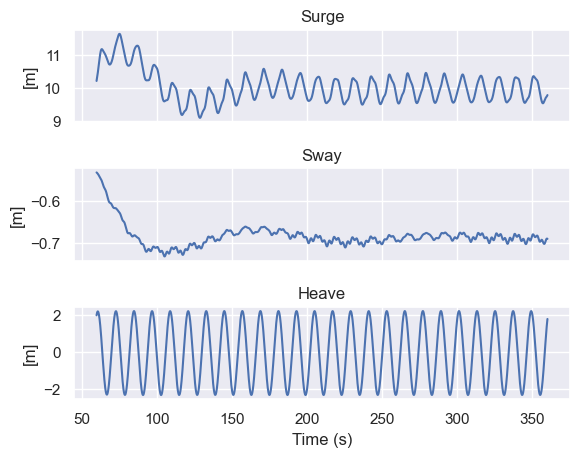

In [70]:
fig, axes = plt.subplots(3, 1, sharex=True)
fig.subplots_adjust(hspace=0.5)
axes[-1].set_xlabel("Time (s)")

names = ["Surge", "Sway", "Heave"]

for i, feat in enumerate(features):
    axes[i].plot(data["Time_[s]"], data[feat], label=feat)
    axes[i].set_title(names[i])
    axes[i].set_ylabel(feat.split("_")[1])

## Approach 1: Autoregressive Model for Tower Top Displacement

This approach uses an autoregressive model to predict future tower top position based on past tower-top position. It uses a linear (Ridge) regressor. Its inputs are the past 1sec of tower top position. In practice, this would necessitate a displacement control scheme based on real-time and past measurements of the tower top position via Qualisys.

Even if we don't use this approach directly for the robotic arm, we could still use it as a fallback in case Qualisys drops a frame.

Text(0.5, 0, 'Timesteps (0.0125 sec)')

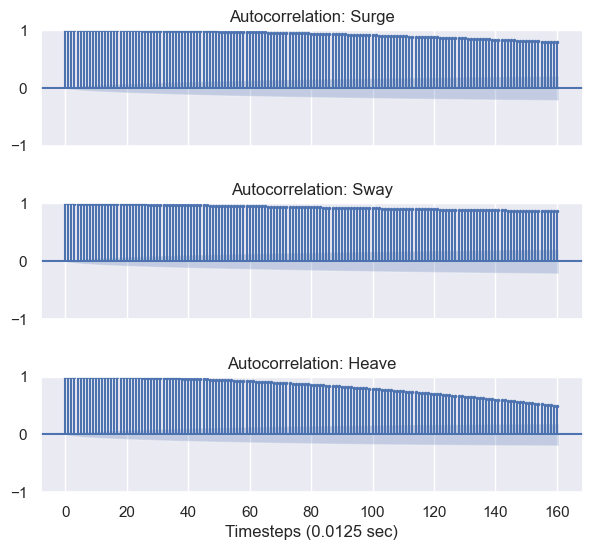

In [71]:
fig, axes = plt.subplots(3, 1, figsize=(7, 6), sharex=True)
fig.subplots_adjust(hspace=0.5)

for i, feat in enumerate(features):
    plot_acf(data[features[i]], ax=axes[i], lags=2/DT, markersize=1.5)
    axes[i].set_title(f"Autocorrelation: {names[i]}")

axes[-1].set_xlabel(f"Timesteps ({DT} sec)")

In [72]:
train, test = train_test_split(data[features], test_size=.2, shuffle=False)

train.index = data.index[:len(train)]
test.index = data.index[:len(test)]

forecaster = ForecasterAutoreg(
    regressor     = Ridge(random_state=123),
    lags          = int(1/DT),
    transformer_y = StandardScaler()
)

forecaster.fit(y=train[features[2]])

In [73]:
metric, predictions = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = data[features[2]],
    initial_train_size = len(train),
    fixed_train_size   = False,
    steps              = 1,
    metric             = 'mean_absolute_error',
    refit              = False,
    verbose            = True
)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 19200
Number of observations used for backtesting: 4801
    Number of folds: 4801
    Number of steps per fold: 1

Data partition in fold: 0
    Training:   1 -- 19200  (n=19200)
    Validation: 19201 -- 19201  (n=1)
Data partition in fold: 1
    Training:   1 -- 19200  (n=19200)
    Validation: 19202 -- 19202  (n=1)
Data partition in fold: 2
    Training:   1 -- 19200  (n=19200)
    Validation: 19203 -- 19203  (n=1)
Data partition in fold: 3
    Training:   1 -- 19200  (n=19200)
    Validation: 19204 -- 19204  (n=1)
Data partition in fold: 4
    Training:   1 -- 19200  (n=19200)
    Validation: 19205 -- 19205  (n=1)
Data partition in fold: 5
    Training:   1 -- 19200  (n=19200)
    Validation: 19206 -- 19206  (n=1)
Data partition in fold: 6
    Training:   1 -- 19200  (n=19200)
    Validation: 19207 -- 19207  (n=1)
Data partition in fold: 7
    Training:   1 -- 1920

/var/folders/rf/cx8s0t556q1061fcn6clgtqr0000gn/T/ipykernel_2698/119299064.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data.loc[train.index, features[2]][-2000:].plot(ax=ax, linewidth=2, label='train')


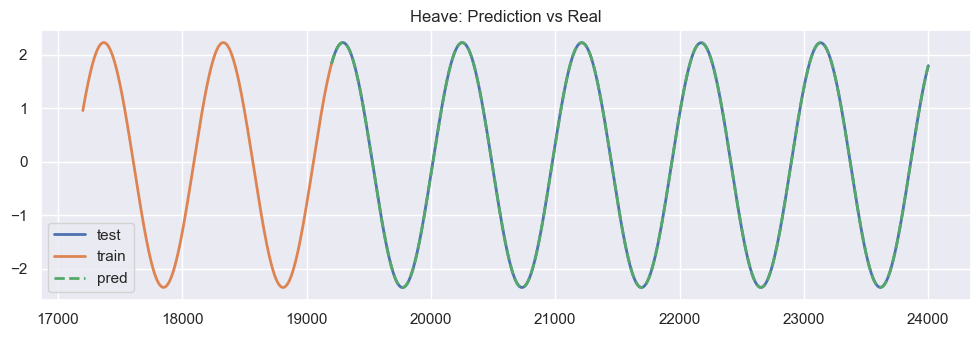

In [74]:
fig, ax = plt.subplots(figsize=(12, 3.5))
data.loc[predictions.index, features[2]].plot(ax=ax, linewidth=2, label='test')
data.loc[train.index, features[2]][-2000:].plot(ax=ax, linewidth=2, label='train')
predictions.plot(linewidth=2, label='prediction', ax=ax, linestyle="dashed")
ax.set_title('Heave: Prediction vs Real')
ax.legend();

In [75]:
print(f'Backtest error (MAE): {metric}')

Backtest error (MAE): 0.0007177319117132985


## Approach 2

This approach attempts to predict the force at the rotor based on the movements of the platform. It uses the 6DOF displacements of the platform as features. It uses Gaussian Process Regression (aka "Kriging") to  

In [76]:
labels = [
    "RtAeroFxh_[N]",
    "RtAeroFyh_[N]",
    "RtAeroFzh_[N]",
    "RtAeroMxh_[N-m]",
    "RtAeroMyh_[N-m]",
    "RtAeroMzh_[N-m]"
]

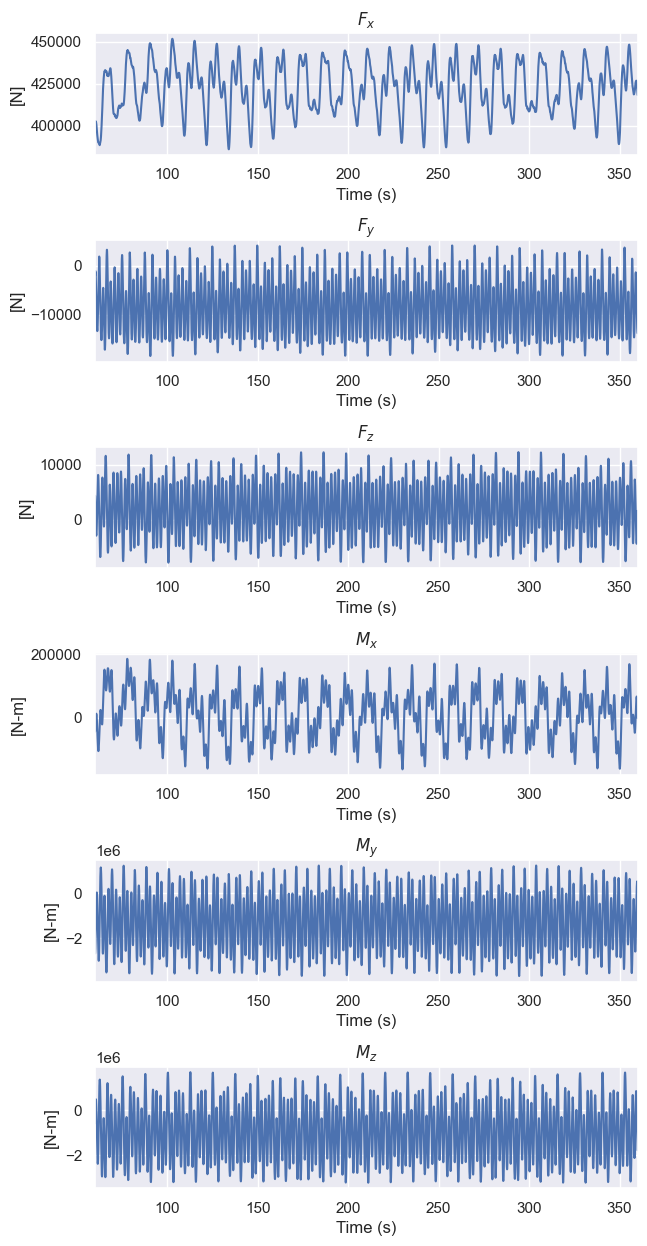

In [77]:
fig, axes = plt.subplots(len(labels), 1, figsize=(7, 15))
fig.subplots_adjust(hspace=0.7)

f_titles = ["$F_x$", "$F_y$", "$F_z$", "$M_x$", "$M_y$", "$M_z$"]

for i, feat in enumerate(labels):
    axes[i].plot(data["Time_[s]"], data[feat], label=feat)
    axes[i].set_title(f_titles[i])
    axes[i].set_xlabel("Time (s)")
    axes[i].set_ylabel(feat.split("_")[1])
    axes[i].set_xmargin(0)

In [78]:
features = [
    "PtfmSurge_[m]",
    "PtfmSway_[m]",
    "PtfmHeave_[m]",
    "PtfmRoll_[deg]",
    "PtfmPitch_[deg]",
    "PtfmYaw_[deg]",
#     "PtfmTVxi_[m/s]",
#     "PtfmTVyi_[m/s]",
#     "PtfmTVzi_[m/s]"
]

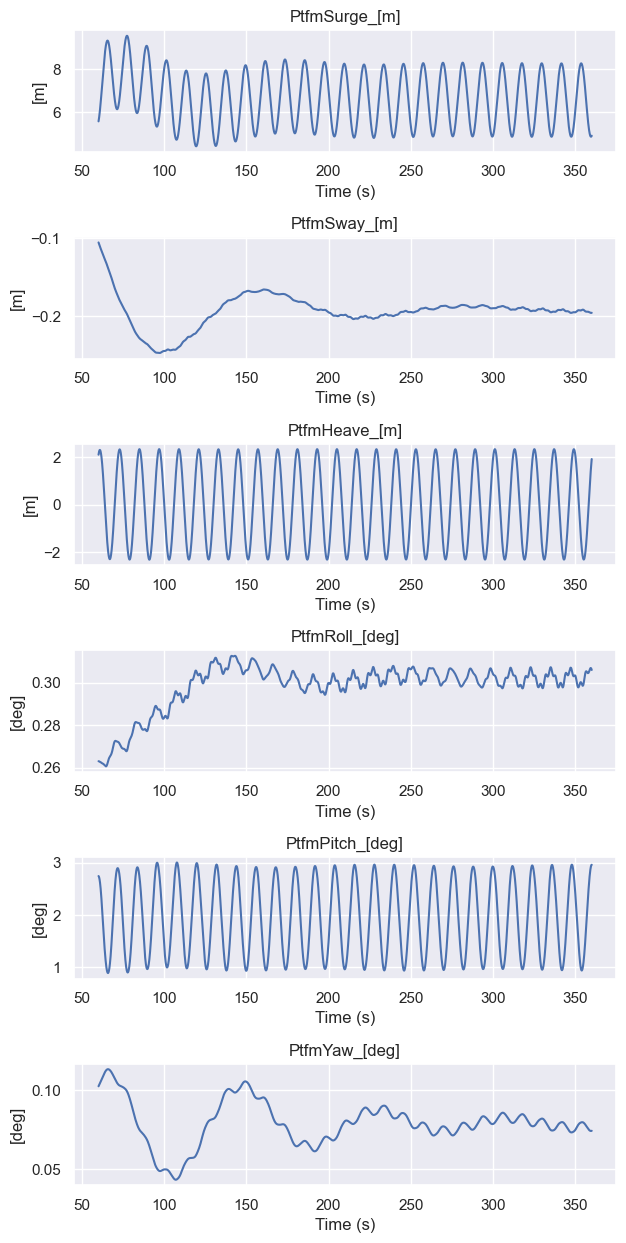

In [79]:
fig, axes = plt.subplots(len(features), 1, figsize=(7, 15))
fig.subplots_adjust(hspace=0.7)

for i, feat in enumerate(features):
    axes[i].plot(data["Time_[s]"], data[feat])
    axes[i].set_title(feat)
    axes[i].set_ylabel(feat.split("_")[1])
    axes[i].set_xlabel("Time (s)")

In [171]:
X = data[features]
y = data[labels]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8)

In [172]:
X_train

,PtfmSurge_[m],PtfmSway_[m],PtfmHeave_[m],PtfmRoll_[deg],PtfmPitch_[deg],PtfmYaw_[deg]
16267,4.862168,-0.191447,1.434659,0.306742,2.891237,0.071611
7395,6.519666,-0.168410,-1.679217,0.309952,1.755153,0.101777
12292,5.523451,-0.201678,-0.469690,0.302153,2.357340,0.079250
6997,7.339573,-0.170626,0.645495,0.304652,1.604606,0.104041
15080,6.557804,-0.194832,-1.699214,0.306598,1.756688,0.081585
...,...,...,...,...,...,...
5247,7.807790,-0.204557,-1.719496,0.302677,0.968504,0.078160
16524,6.621148,-0.189508,1.685834,0.302258,2.119627,0.073696
5023,6.455794,-0.211750,1.354171,0.301318,1.976676,0.069313
12551,5.253844,-0.203071,2.343447,0.302076,2.791716,0.080368


In [209]:
len(qtm)

26064

In [173]:
X_train.describe()

,PtfmSurge_[m],PtfmSway_[m],PtfmHeave_[m],PtfmRoll_[deg],PtfmPitch_[deg],PtfmYaw_[deg]
count,19200.000000,19200.000000,19200.000000,19200.000000,19200.000000,19200.000000
mean,6.660905,-0.193740,0.018083,0.298477,1.951651,0.079229
std,1.281181,0.021601,1.644046,0.010725,0.704702,0.013908
min,4.397646,-0.247136,-2.327616,0.260628,0.893154,0.043523
25%,5.445525,-0.199466,-1.621476,0.297853,1.246693,0.073044
50%,6.670966,-0.191843,0.024948,0.301480,1.955767,0.079146
75%,7.824616,-0.186523,1.653446,0.304686,2.654003,0.085231
max,9.581419,-0.105726,2.352731,0.312580,3.004032,0.113392


In [176]:
# results = pd.DataFrame({"$R^2$": scores, "RMSE": rmse, "MAE": mae}, index=f_titles)

# results

In [188]:
rf = RandomForestRegressor(oob_score=True)
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train, y_train)
rf.fit(X_train_std, y_train)

RandomForestRegressor(oob_score=True)

In [189]:
rf.oob_score_

0.9986612244824031

In [192]:
scaler = StandardScaler()
X_test_std = scaler.fit_transform(X_test, y_test)
rf.score(X_test_std, y_test)

0.9451735807805673

## Analyzing Raw QTM Data

In [196]:
qtm = pd.read_csv("../data/Trial0002_6D_nogaps.tsv", sep="\t", header=13)
qtm.index = qtm["Time"]
qtm = qtm[["SemiSub X", "Y", "Z", "Roll", "Pitch", "Yaw"]]
qtm.columns = X.columns
# xyz_norm = qtm[["X", "Y", "Z"]].transform(lambda x: (x - x.mean()) / 1000)
# qtm[["X", "Y", "Z"]] = xyz_norm
# qtm = qtm.transform(lambda x: x * 50)
qtm.head()

,PtfmSurge_[m],PtfmSway_[m],PtfmHeave_[m],PtfmRoll_[deg],PtfmPitch_[deg],PtfmYaw_[deg]
Time,,,,,,
0.00,-2842.75103,-1765.54479,-728.24072,0.07329,0.13515,0.06491
0.01,-2842.74951,-1765.54830,-728.24049,0.07332,0.13498,0.06639
0.02,-2842.74751,-1765.56319,-728.24403,0.07237,0.13547,0.06720
0.03,-2842.71147,-1765.55370,-728.25556,0.07513,0.13330,0.06561
0.04,-2842.70049,-1765.55364,-728.25578,0.07509,0.13166,0.06690


In [197]:
qtm_std = StandardScaler().fit_transform(qtm)
pred = rf.predict(qtm_std)
pred = pd.DataFrame(pred, columns=y.columns)
pred

,RtAeroFxh_[N],RtAeroFyh_[N],RtAeroFzh_[N],RtAeroMxh_[N-m],RtAeroMyh_[N-m],RtAeroMzh_[N-m]
0,421556.737600,-6841.395839,8289.559357,-57679.903765,-2.699475e+06,-2.179859e+06
1,421556.737600,-6841.395839,8289.559357,-57679.903765,-2.699475e+06,-2.179859e+06
2,425565.643323,-5194.080602,6980.307325,-33749.430160,-2.772956e+06,-1.767852e+06
3,421556.737600,-6841.395839,8289.559357,-57679.903765,-2.699475e+06,-2.179859e+06
4,421556.737600,-6841.395839,8289.559357,-57679.903765,-2.699475e+06,-2.179859e+06
...,...,...,...,...,...,...
26059,432490.329962,-7361.828527,120.410705,59035.266364,-1.016429e+06,-3.062470e+05
26060,432208.635745,-7459.814267,71.650647,58384.415254,-9.904124e+05,-3.147688e+05
26061,432901.981631,-8136.906936,-692.023024,70428.257581,-7.148900e+05,-2.675479e+05
26062,432180.617569,-9234.560951,-1909.254796,80459.324071,-2.677248e+05,-2.127628e+05


In [240]:
start = time()
pred = rf.predict(qtm_std)
total = time() - start
print(f"Average prediction time: {total/len(qtm_std)} sec")

Average prediction time: 1.5341161657067586e-05 sec


In [89]:
qtm.isnull().sum()

X        0
Y        0
Z        0
Roll     0
Pitch    0
Yaw      0
dtype: int64

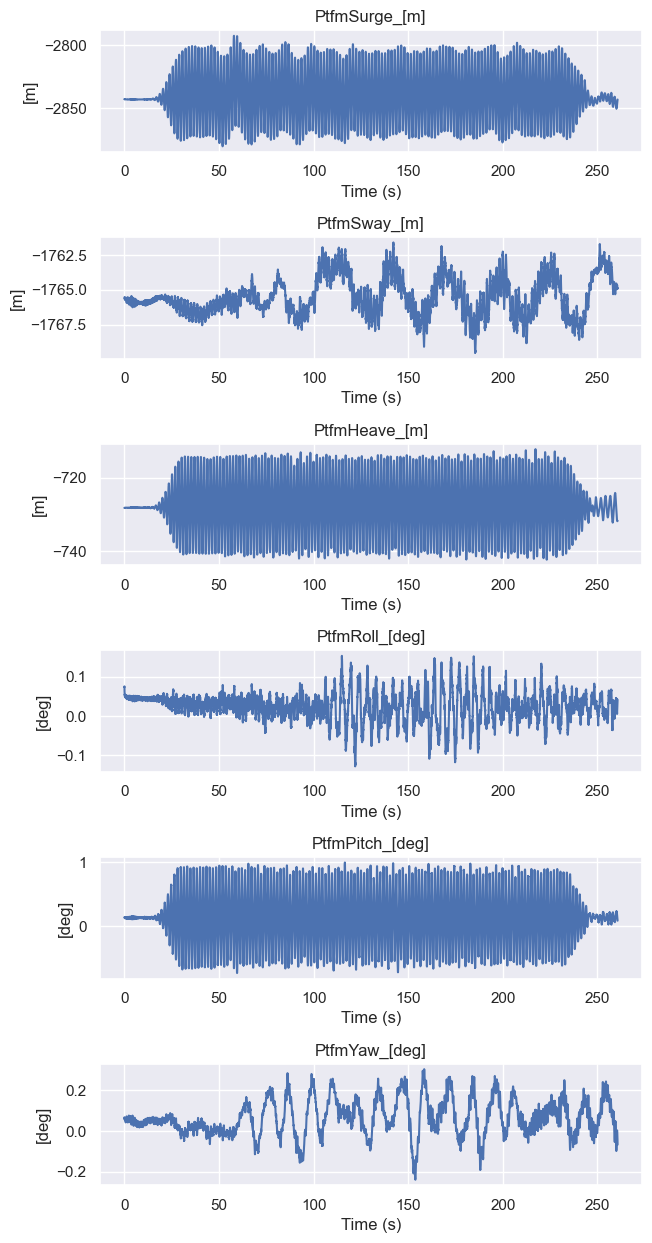

In [242]:
fig, axes = plt.subplots(len(qtm.columns), 1, figsize=(7, 15))
fig.subplots_adjust(hspace=0.7)

for i, feat in enumerate(qtm.columns):
    axes[i].plot(qtm.index, qtm[feat])
    axes[i].set_title(feat)
    axes[i].set_ylabel(feat.split("_")[1])
    axes[i].set_xlabel("Time (s)")

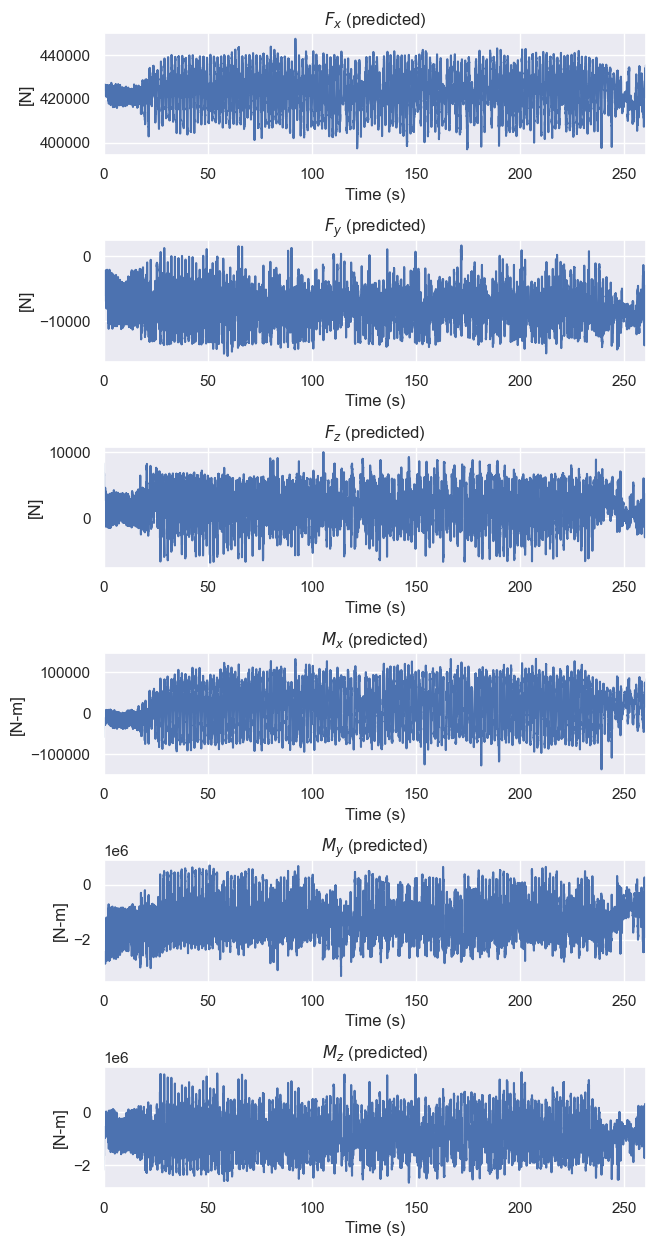

In [211]:

fig, axes = plt.subplots(len(labels), 1, figsize=(7, 15))
fig.subplots_adjust(hspace=0.7)

f_titles = ["$F_x$", "$F_y$", "$F_z$", "$M_x$", "$M_y$", "$M_z$"]

for i, feat in enumerate(labels):
    axes[i].plot(qtm.index, pred[feat], label=feat)
    axes[i].set_title(f"{f_titles[i]} (predicted)")
    axes[i].set_xlabel("Time (s)")
    axes[i].set_ylabel(feat.split("_")[1])
    axes[i].set_xmargin(0)